In [4]:
# Vezetői készségteszt – önértékelés vs. rólam értékelt adatok összehasonlítása
#
# Ebben a jegyzetfüzetben az "adatok/sajat" (önértékelés) és "adatok/rolam" (mások általi értékelés)
# CSV állományait hasonlítjuk össze. Cél: sokféle, jól olvasható ábra (matplotlib + seaborn),
# csoportos, alcsoportos és kérdés-szintű bontásban, valamint különbségek és korrelációk.

import sys
from pathlib import Path

# Könyvtárak importja – ha valamelyik hiányzik, egy külön cellában telepítjük
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy import stats
    HAVE_ALL_DEPS = True
except Exception as e:
    HAVE_ALL_DEPS = False
    print("Hiányzó csomag(ok):", e)

sns.set_theme(context="notebook", style="whitegrid", palette="deep")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 10

# Útvonalak (a notebook mappájához képest)
BASE = Path.cwd()
ADATOK = BASE / "adatok"
SAJAT_DIR = ADATOK / "sajat"
ROLAM_DIR = ADATOK / "rolam"
FIG_DIR = BASE / "figures"
FIG_DIR.mkdir(exist_ok=True)

SAJAT_VAL = SAJAT_DIR / "pams_export_20251113_valaszok.csv"
SAJAT_RES = SAJAT_DIR / "pams_export_20251113_eredmenyek.csv"
ROLAM_VAL = ROLAM_DIR / "pams_export_20251113_valaszok.csv"
ROLAM_RES = ROLAM_DIR / "pams_export_20251113_eredmenyek.csv"

SAJAT_VAL.exists(), SAJAT_RES.exists(), ROLAM_VAL.exists(), ROLAM_RES.exists()

(True, True, True, True)

In [7]:
# Telepítés (ha szükséges) – ezt csak akkor futtasd, ha az első cella szerint hiányzik valamelyik csomag
# pip install pandas numpy matplotlib seaborn scipy  # opcionális; a futtatókörnyezetben már elérhető lehet
pass

In [5]:
# Adatok betöltése és előkészítése
import re

def read_valaszok(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df.rename(columns={"answer": "answer_val"})
    df["id"] = df["id"].astype(int)
    return df[["id", "text", "answer_val"]]


def pct_to_float(series: pd.Series) -> pd.Series:
    # '72%' -> 72.0
    return series.astype(str).str.replace('%', '', regex=False).replace('', np.nan).astype(float)


def read_eredmenyek(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # normalizáljuk a százalékot numerikusra
    df["pct_num"] = pct_to_float(df["pct"])  # 0..100
    return df

range_pat = re.compile(r"\((\d+)\s*[–-]\s*(\d+)\)")

def strip_range(label: str) -> str:
    return re.sub(r"\s*\(\d+\s*[–-]\s*\d+\)\s*", "", str(label)).strip()


def parse_range_from_label(label: str):
    m = range_pat.search(str(label))
    if not m:
        return None
    a, b = int(m.group(1)), int(m.group(2))
    if a > b:
        a, b = b, a
    return a, b


def build_question_mapping(df_res: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for _, r in df_res.iterrows():
        rng = parse_range_from_label(r["label"])
        if not rng:
            continue
        a, b = rng
        span = b - a + 1
        for q in range(a, b + 1):
            rows.append({
                "id": q,
                "main_group": r.get("group"),
                "parent": r.get("subgroup"),
                "category": strip_range(r.get("label")),
                "span": span,
            })
    map_df = pd.DataFrame(rows)
    # azonos kérdés – tartsuk meg a legrészletesebb (legkisebb span) kategóriát
    map_df = map_df.sort_values(["id", "span"]).drop_duplicates(subset=["id"], keep="first").drop(columns=["span"])
    return map_df

# Betöltés
sajat_val = read_valaszok(SAJAT_VAL).rename(columns={"answer_val": "self"})
rolam_val = read_valaszok(ROLAM_VAL).rename(columns={"answer_val": "others"})
val = sajat_val.merge(rolam_val[["id", "others"]], on="id", how="inner")

sajat_res = read_eredmenyek(SAJAT_RES).assign(source="self")
rolam_res = read_eredmenyek(ROLAM_RES).assign(source="others")
res_all = pd.concat([sajat_res, rolam_res], ignore_index=True)

# Kérdés-szintű mapping felépítése az eredményekből
qmap = build_question_mapping(sajat_res)
val = val.merge(qmap, on="id", how="left")

# derivált metrikák
val["diff"] = val["others"] - val["self"]
val["abs_diff"] = val["diff"].abs()

val.head(), res_all.head(), qmap.head()

(   id                                               text  self  others  \
 0   1  Az erősségeimre és gyengeségeimre vonatkozó me...     3       6   
 1   2  Annak érdekében, hogy fejlesszem önmagam, máso...     5       6   
 2   3  Tisztában vagyok azzal, hogy milyen stílusban ...     5       6   
 3   4  Jól érzékem van ahhoz, hogy megbirkózzak a két...     5       5   
 4   5  Jól kidolgozott személyes viselkedési modellem...     3       4   
 
                main_group                 parent                 category  \
 0  I. Személyes készségek  Önismeret fejlesztése  Önismeret és nyitottság   
 1  I. Személyes készségek  Önismeret fejlesztése  Önismeret és nyitottság   
 2  I. Személyes készségek  Önismeret fejlesztése             Az önismeret   
 3  I. Személyes készségek  Önismeret fejlesztése             Az önismeret   
 4  I. Személyes készségek  Önismeret fejlesztése             Az önismeret   
 
    diff  abs_diff  
 0     3         3  
 1     1         1  
 2     1       

In [ ]:
# Ábrázolási segédfüggvények
from textwrap import shorten, fill


def safe_fname(title: str) -> str:
    safe = re.sub(r"[^0-9A-Za-záéíóöőúüűÁÉÍÓÖŐÚÜŰ\- ]+", "_", title).strip().replace(" ", "_")
    return safe[:120]


def savefig(fig, title: str, tight=True):
    fname = safe_fname(title)
    p_png = FIG_DIR / f"{fname}.png"
    p_svg = FIG_DIR / f"{fname}.svg"
    if tight:
        fig.tight_layout()
    fig.savefig(p_png, dpi=200)
    fig.savefig(p_svg)
    print("Mentve:", p_png.name, "/", p_svg.name)


,def bar_compare(df, x, y_self, y_others, title, xlabel=None, ylabel=None, order=None, rotate=0, show_labels=True, label_fmt="{:.0f}"):
    if order is None:
        order = df[x].tolist()
    fig, ax = plt.subplots(figsize=(12, max(5, 0.4*len(order))))
    idx = np.arange(len(order))
    w = 0.38
    dfo = df.set_index(x).loc[order].reset_index()

    bars_self = ax.bar(idx - w/2, dfo[y_self], width=w, label="Önértékelés", color=sns.color_palette()[0])
    bars_oth  = ax.bar(idx + w/2, dfo[y_others], width=w, label="Mások rólam", color=sns.color_palette()[1])

    ax.set_title(title)
    ax.set_xlabel(xlabel or "")
    ax.set_ylabel(ylabel or "Érték")
    ax.set_xticks(idx, [fill(str(v), 30) for v in order], rotation=rotate, ha='right' if rotate else 'center')
    ax.legend()

    if show_labels:
        self_vals = dfo[y_self].to_numpy()
        oth_vals  = dfo[y_others].to_numpy()
        for i in range(len(idx)):
            sv = self_vals[i]
            if pd.notna(sv):
                ax.text(idx[i]-w/2, sv/2, label_fmt.format(sv), ha='center', va='center', color='white', fontsize=9, fontweight='bold', zorder=5)
            ov = oth_vals[i]
            if pd.notna(ov):
                ax.text(idx[i]+w/2, ov/2, label_fmt.format(ov), ha='center', va='center', color='white', fontsize=9, fontweight='bold', zorder=5)

    sns.despine(ax=ax)
    savefig(fig, title)
    return fig, ax


def lollipop_top_diffs(dfq, top=10, title_prefix=""):
    d = dfq.copy()
    d = d.sort_values("abs_diff", ascending=False).head(top)
    d = d.sort_values("diff")
    fig, ax = plt.subplots(figsize=(12, max(5, 0.45*len(d))))
    ax.hlines(y=np.arange(len(d)), xmin=0, xmax=d["diff"], color="gray", alpha=0.3)
    colors = [sns.color_palette()[1] if v>0 else sns.color_palette()[0] for v in d["diff"]]
    ax.scatter(d["diff"], np.arange(len(d)), color=colors, s=80)
    ax.set_yticks(np.arange(len(d)), [fill(shorten(t, 80), 40) for t in d["text"]])
    ax.axvline(0, color='k', lw=1)
    ax.set_xlabel("Különbség (Mások – Én)")
    ax.set_title(f"{title_prefix} – Top {top} kérdéskülönbség (|diff|)")
    sns.despine(ax=ax)
    savefig(fig, f"{title_prefix} Top {top} kérdéskülönbség")
    return fig, ax


def scatter_self_vs_others(dfq, title="Én vs. mások – kérdés szinten"):
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.regplot(data=dfq, x="self", y="others", ax=ax, scatter_kws={"s":50, "alpha":0.8})
    lims = [0.5, 6.5]
    ax.plot(lims, lims, ls='--', color='k', alpha=0.6)
    ax.set_xlim(lims); ax.set_ylim(lims)
    r, p = stats.pearsonr(dfq["self"], dfq["others"]) if len(dfq) else (np.nan, np.nan)
    ax.set_title(f"{title}\nPearson r={r:.2f} (p={p:.3f})")
    ax.set_xlabel("Önértékelés")
    ax.set_ylabel("Mások rólam")
    sns.despine(ax=ax)
    savefig(fig, title)
    return fig, ax


def bland_altman(dfq, title="Bland–Altman – kérdés szinten"):
    m = (dfq["self"] + dfq["others"]) / 2
    d = dfq["others"] - dfq["self"]
    md = d.mean()
    sd = d.std(ddof=1)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(m, d, alpha=0.8)
    ax.axhline(md, color='r', linestyle='-')
    ax.axhline(md + 1.96*sd, color='r', linestyle='--')
    ax.axhline(md - 1.96*sd, color='r', linestyle='--')
    ax.set_xlabel("Átlag (Én + Mások)/2")
    ax.set_ylabel("Különbség (Mások – Én)")
    ax.set_title(f"{title}\nÁtlag diff={md:.2f}, LOA=[{md-1.96*sd:.2f}, {md+1.96*sd:.2f}]")
    sns.despine(ax=ax)
    savefig(fig, title)
    return fig, ax


def heatmap_category_diff(dfq_cat, title="Kategória szintű különbségek (Mások – Én)"):
    # dfq_cat: columns [category, main_group, self, others, diff]
    piv = (dfq_cat
           .pivot_table(index=["main_group", "category"], values="diff", aggfunc="mean")
           .reset_index())
    piv["row"] = piv["main_group"].astype(str) + " | " + piv["category"].astype(str)
    piv = piv.sort_values(["main_group", "category"])    
    mat = piv[["diff"]].to_numpy().reshape(-1, 1)
    fig, ax = plt.subplots(figsize=(6, max(5, 0.35*len(piv))))
    sns.heatmap(mat, annot=True, fmt=".2f", cmap="coolwarm", center=0, cbar=True, yticklabels=piv["row"], xticklabels=["Különbség"]) 
    ax.set_title(title)
    savefig(fig, title)
    return fig, ax


def radar_chart(labels, values_self, values_others, title):
    # Polar diagram 0..100 skálán
    N = len(labels)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    values_self = list(values_self) + [values_self[0]]
    values_others = list(values_others) + [values_others[0]]
    angles += angles[:1]
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, values_self, label="Önértékelés", color=sns.color_palette()[0])
    ax.fill(angles, values_self, alpha=0.15, color=sns.color_palette()[0])
    ax.plot(angles, values_others, label="Mások rólam", color=sns.color_palette()[1])
    ax.fill(angles, values_others, alpha=0.15, color=sns.color_palette()[1])
    ax.set_thetagrids(np.degrees(angles[:-1]), [shorten(l, 30) for l in labels])
    # place the title as a figure-level text and force it on top (high zorder)
    ttl = fig.suptitle(title, y=1.08)
    ttl.set_zorder(9999)
    # optional: give the title a (possibly transparent) bbox so it's clearly readable above plotted elements
    ttl.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.6, zorder=9999))
    ax.set_rlabel_position(0)
    ax.set_ylim(0, 100)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    savefig(fig, title)
    return fig, ax

Mentve: Főcsoportok___pontszámok__Én_vs__mások_.png / Főcsoportok___pontszámok__Én_vs__mások_.svg
Mentve: I__Személyes_készségek___alcsoport-összegzések__pont_.png / I__Személyes_készségek___alcsoport-összegzések__pont_.svg
Mentve: I__Személyes_készségek___alcsoport-összegzések__pont_.png / I__Személyes_készségek___alcsoport-összegzések__pont_.svg
Mentve: I__Személyes_készségek___radar__alcsoport-összegzések_.png / I__Személyes_készségek___radar__alcsoport-összegzések_.svg
Mentve: I__Személyes_készségek___radar__alcsoport-összegzések_.png / I__Személyes_készségek___radar__alcsoport-összegzések_.svg
Mentve: II__Interperszonális_készségek___alcsoport-összegzések__pont_.png / II__Interperszonális_készségek___alcsoport-összegzések__pont_.svg
Mentve: II__Interperszonális_készségek___alcsoport-összegzések__pont_.png / II__Interperszonális_készségek___alcsoport-összegzések__pont_.svg
Mentve: II__Interperszonális_készségek___radar__alcsoport-összegzések_.png / II__Interperszonális_készségek___

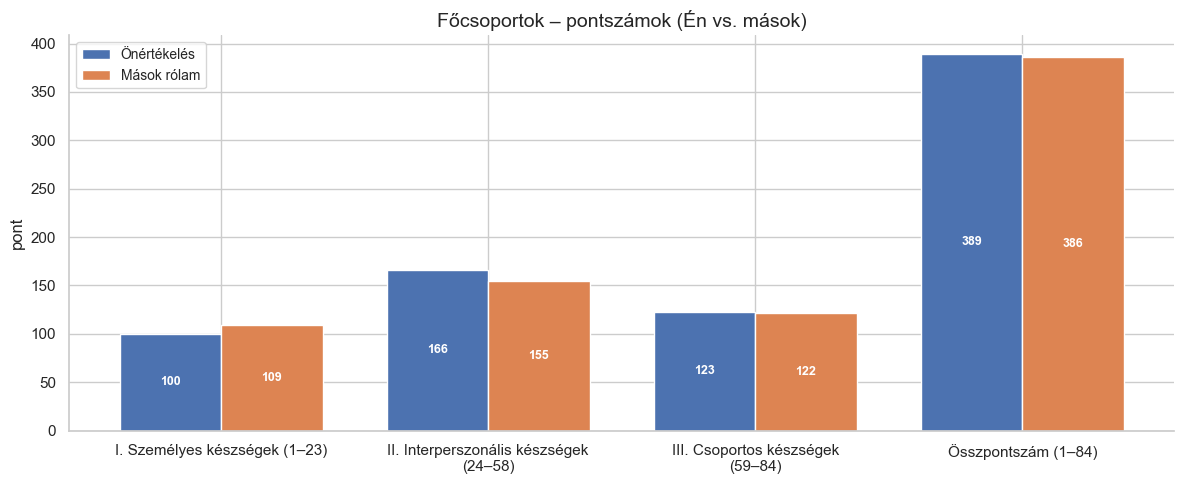

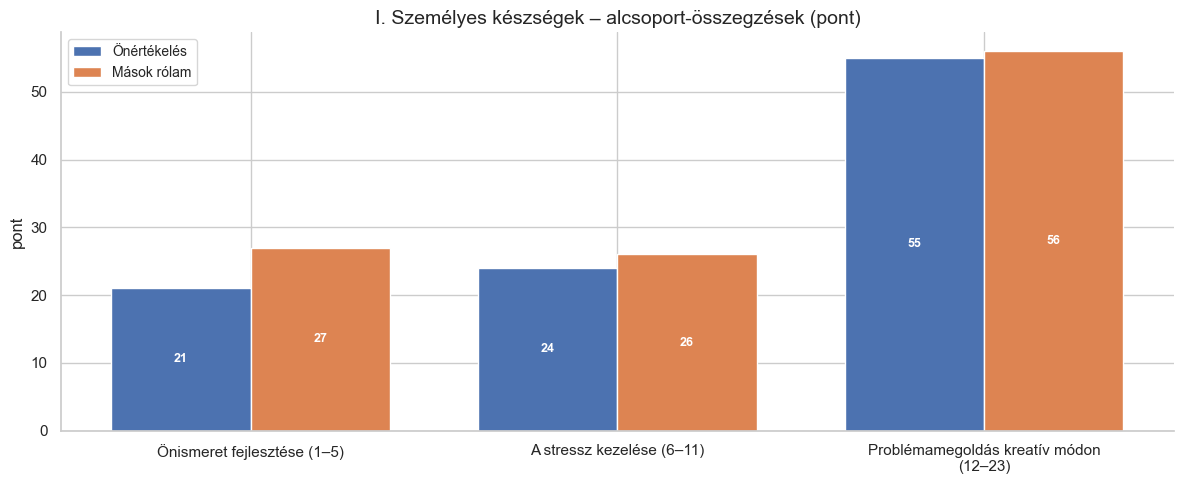

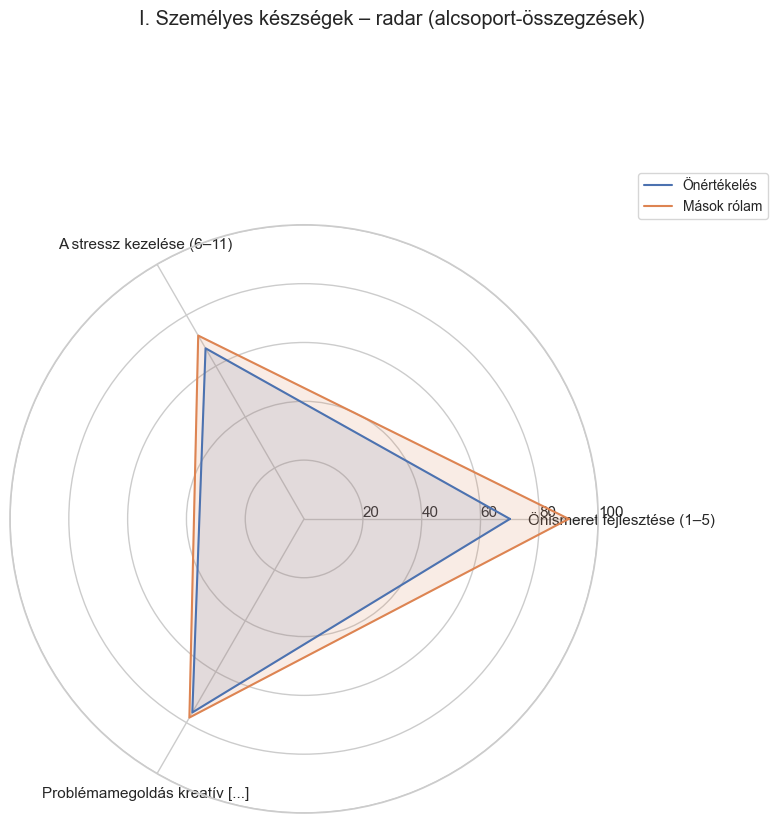

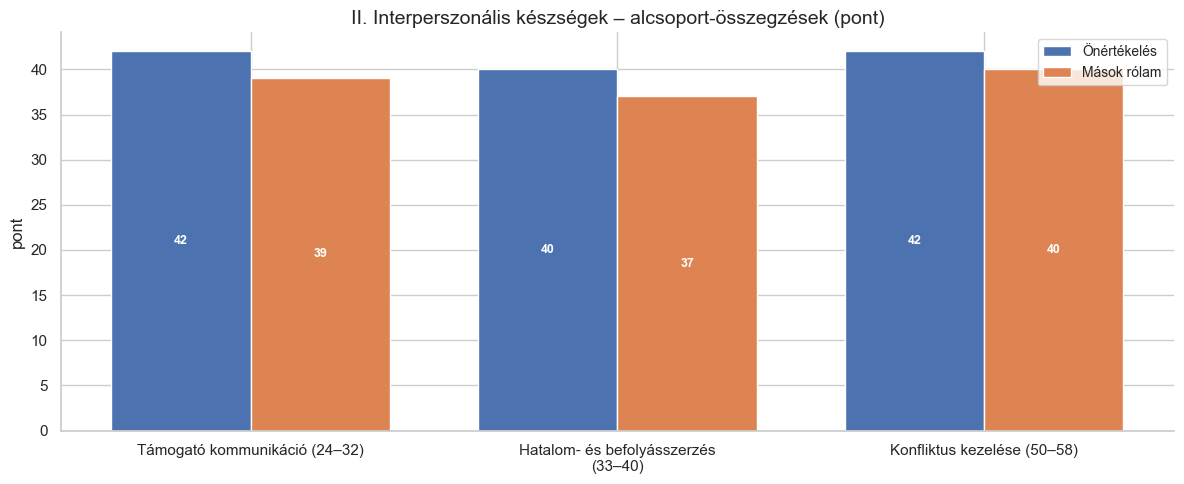

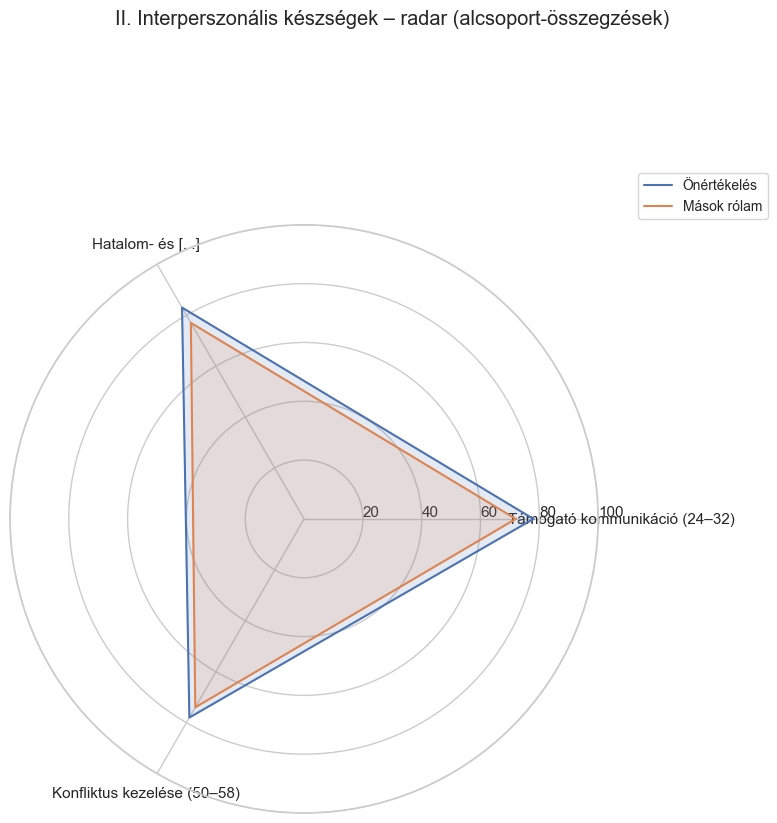

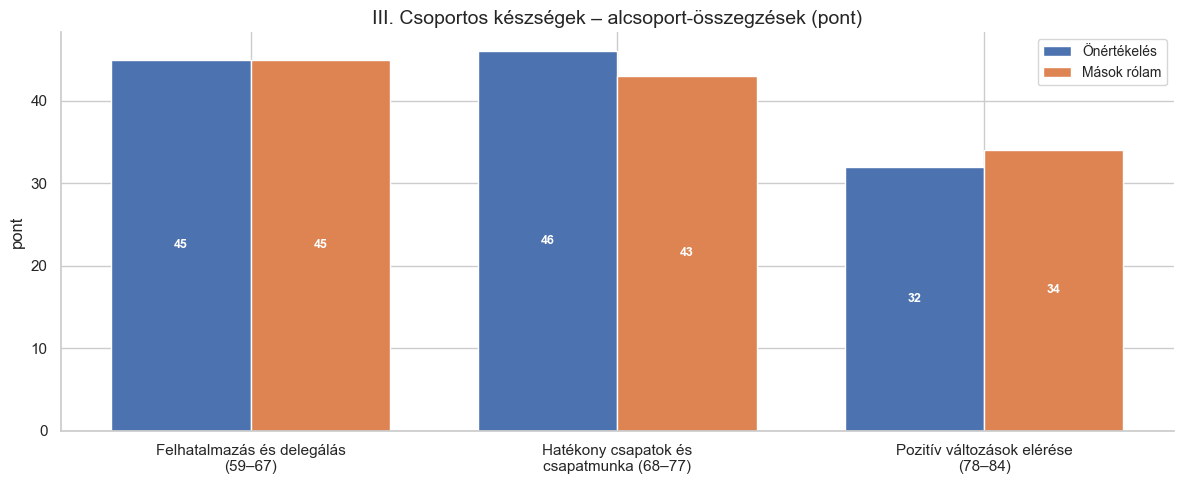

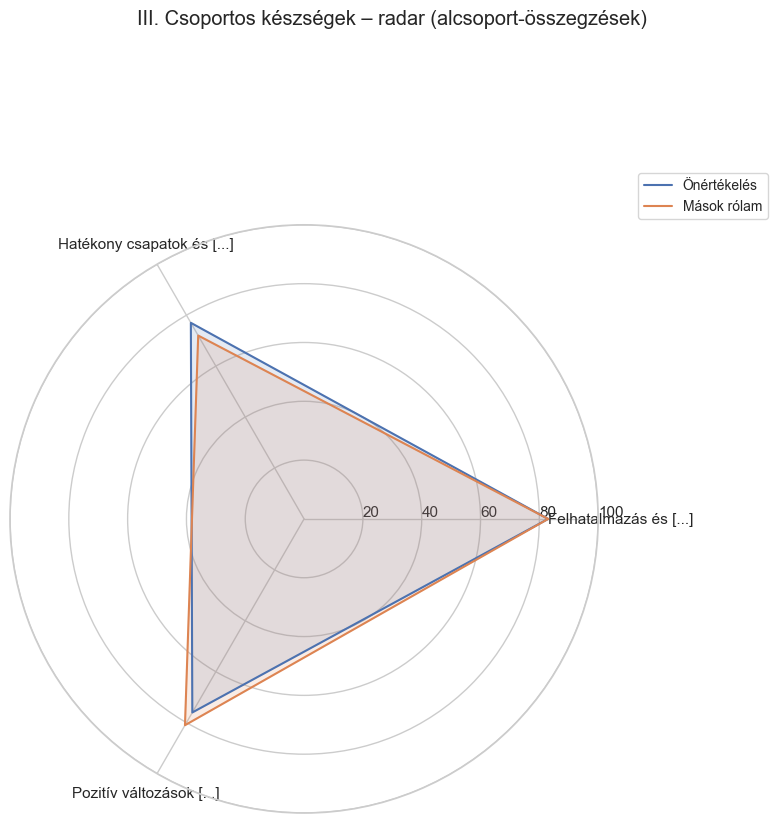

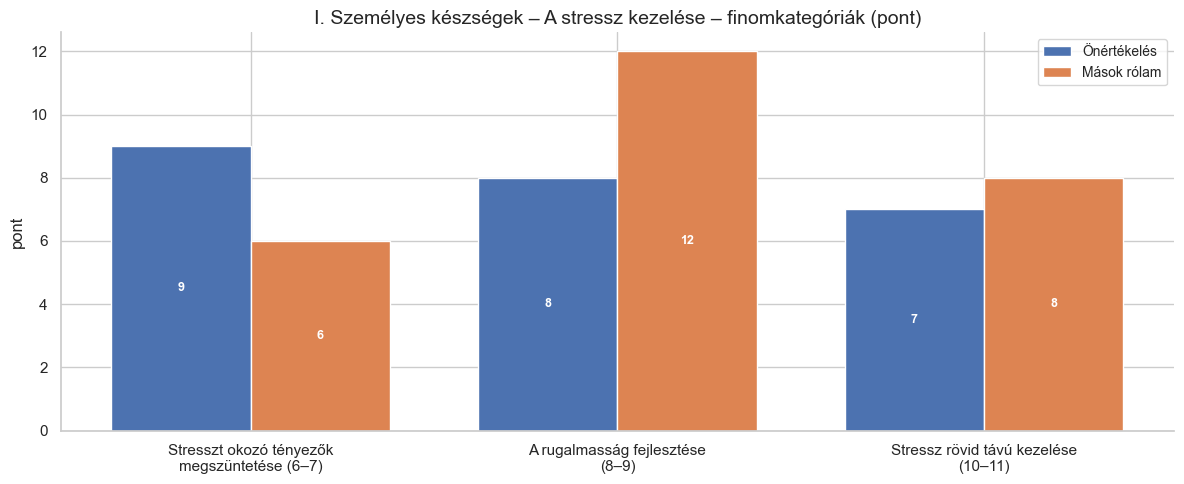

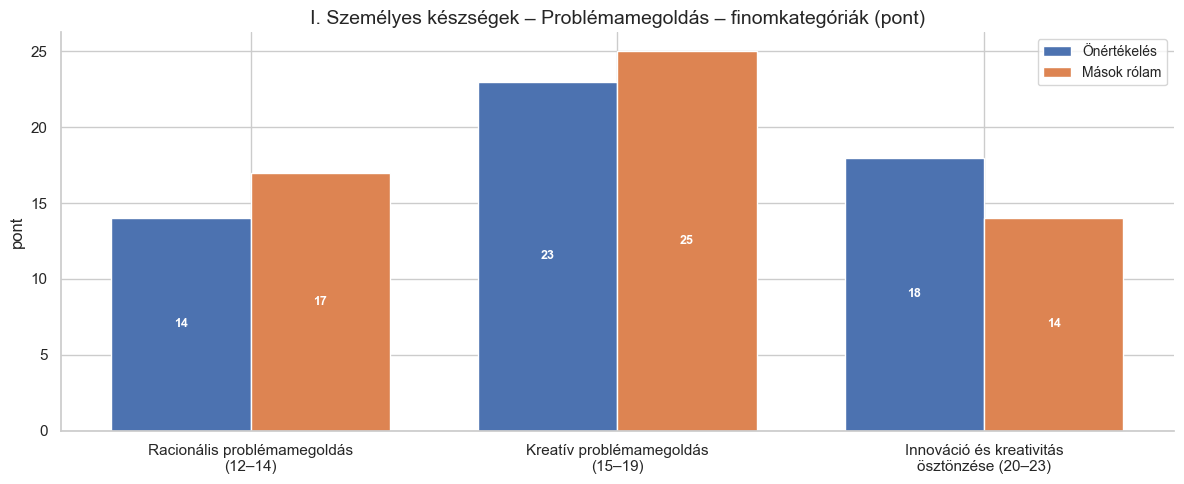

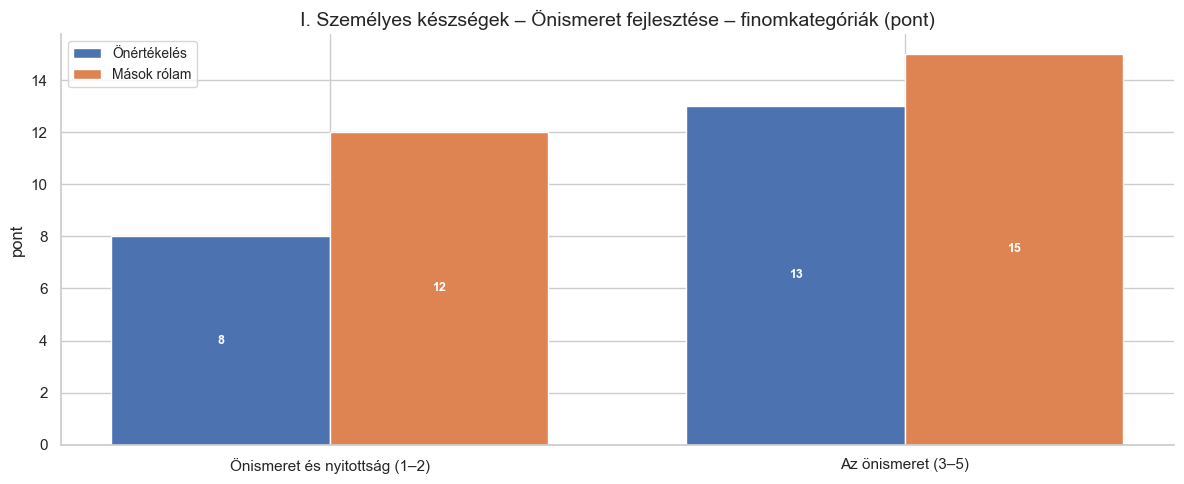

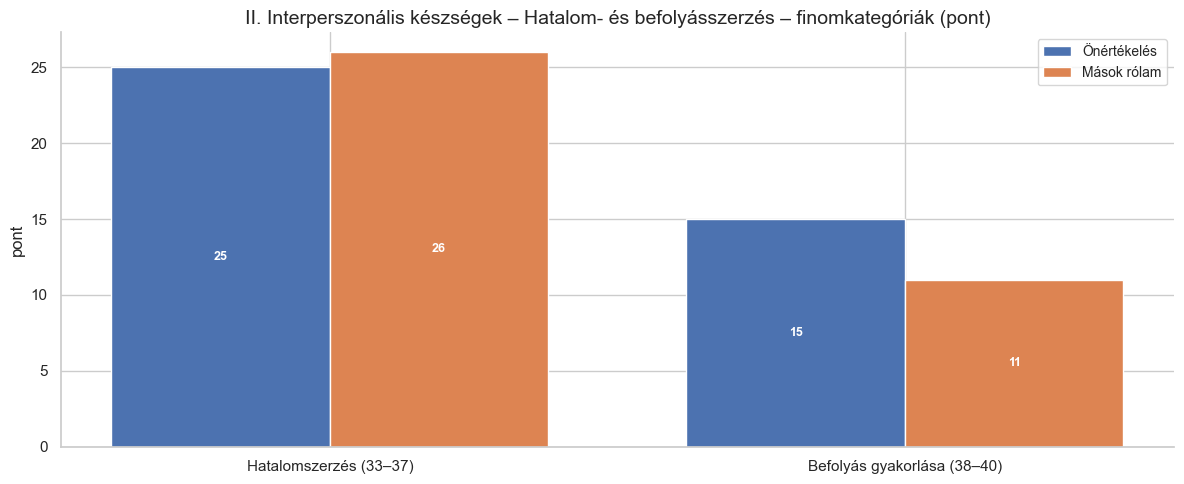

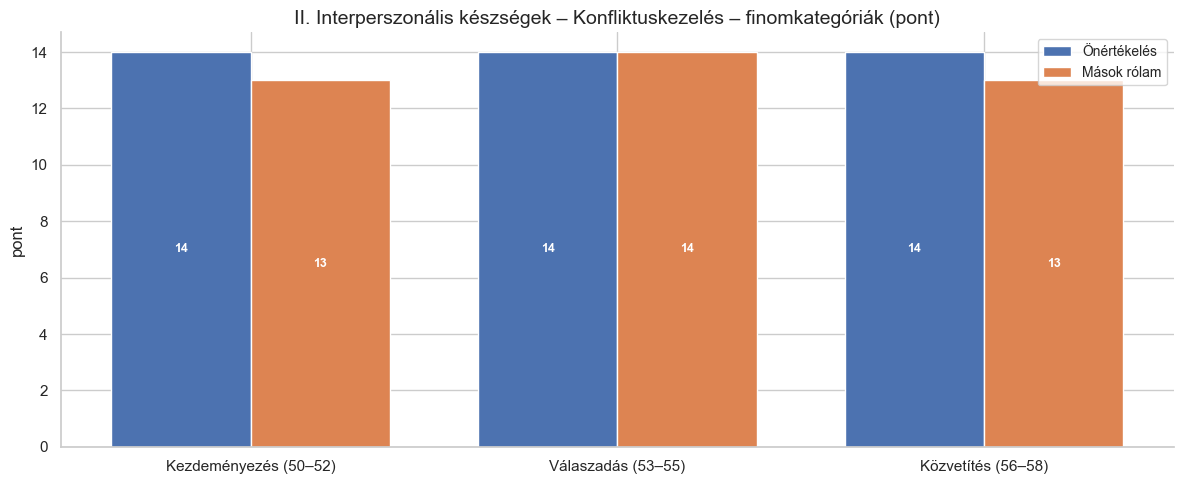

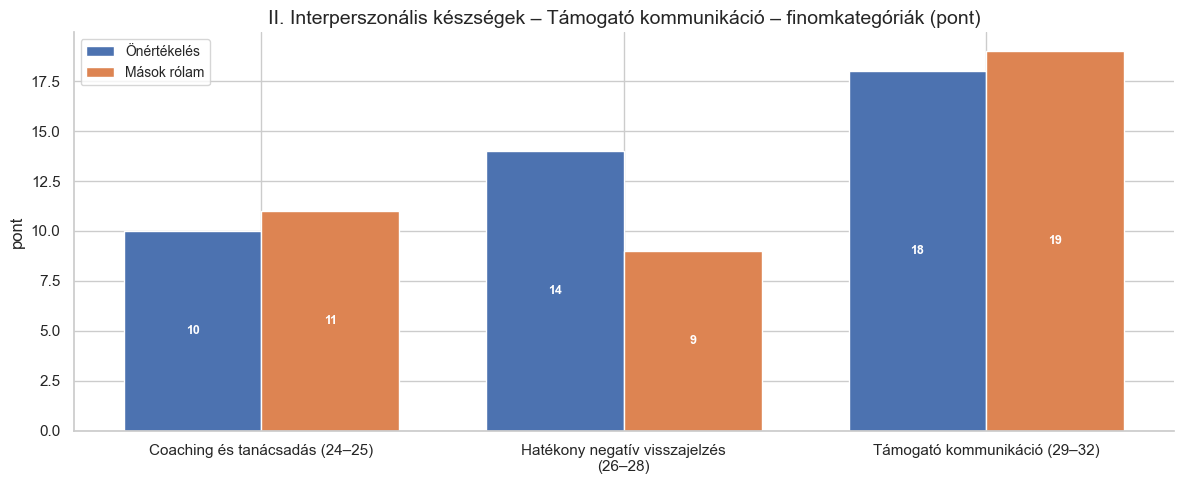

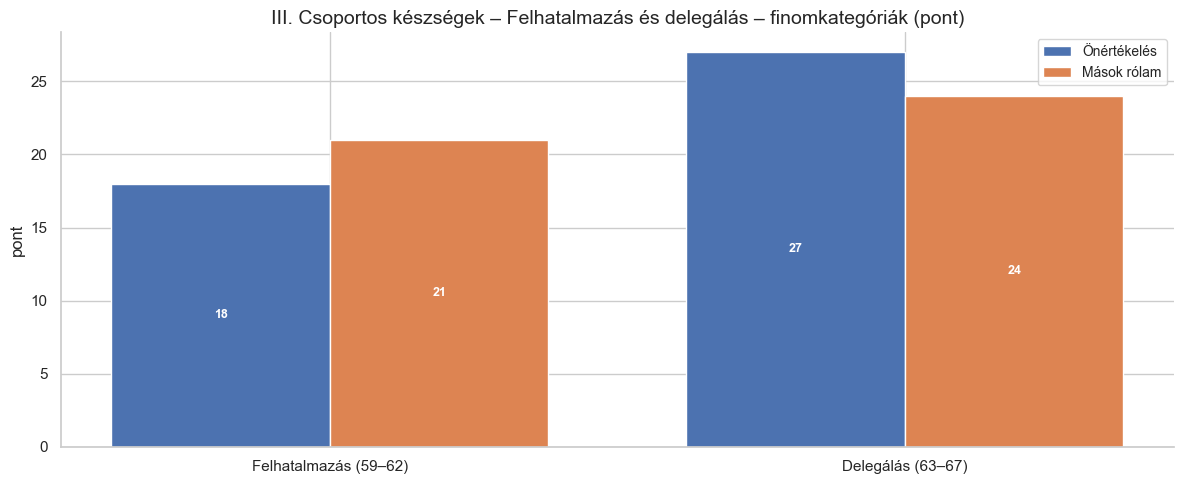

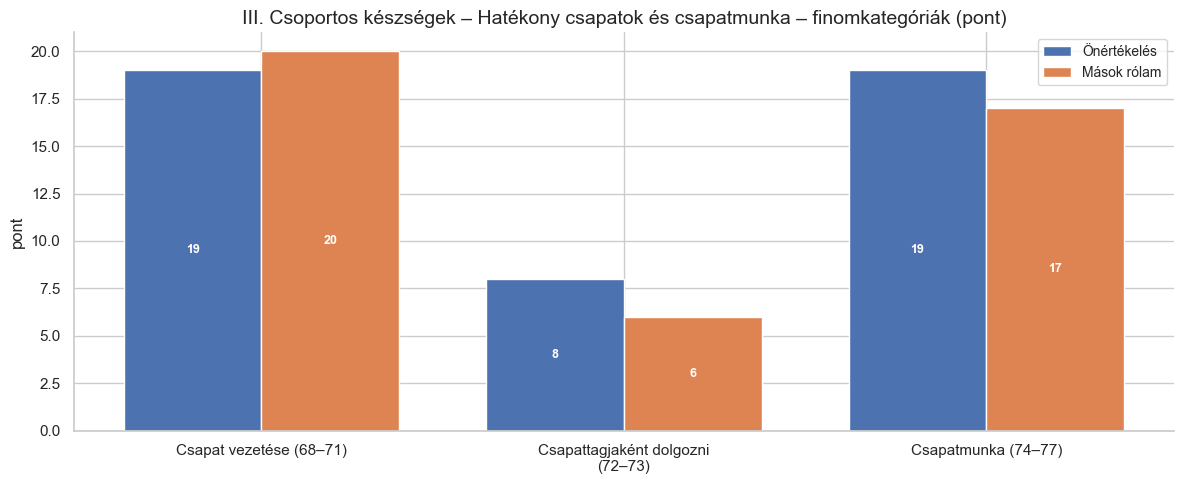

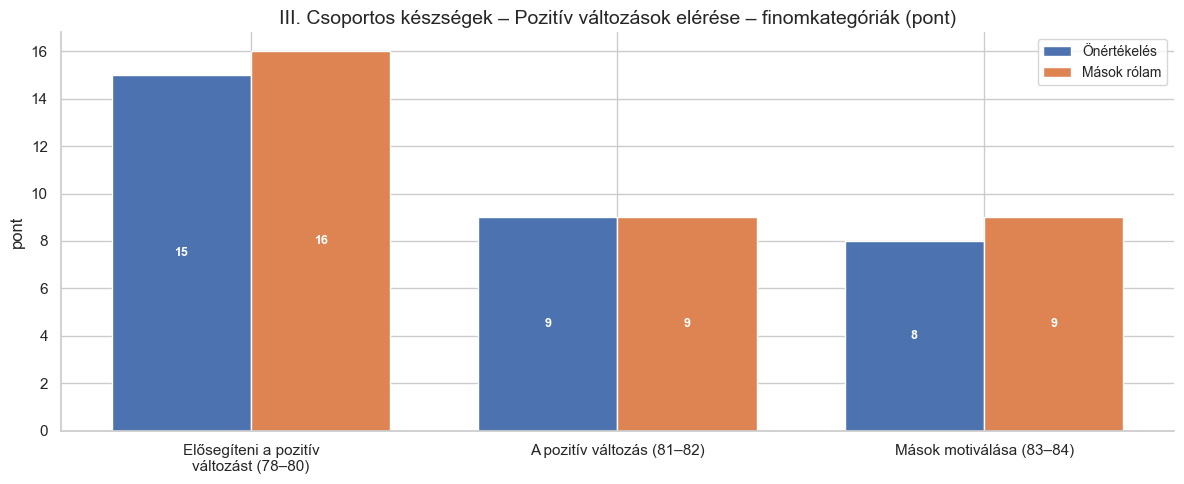

In [7]:
# Főbb összefoglaló ábrák az 'eredmenyek' alapján
# 1) Főcsoportok (I, II, III, TOTAL) összehasonlítása
main_keys = ["I_total", "II_total", "III_total", "TOTAL"]
# Bar chart: pontszámok az Y tengelyen
main_self_pts = sajat_res[sajat_res["key"].isin(main_keys)][["key", "label", "score"]].rename(columns={"score":"self"})
main_oth_pts  = rolam_res[rolam_res["key"].isin(main_keys)][["key", "label", "score"]].rename(columns={"score":"others"})
main_pts = main_self_pts.merge(main_oth_pts, on=["key", "label"], how="inner")
bar_compare(main_pts, x="label", y_self="self", y_others="others", title="Főcsoportok – pontszámok (Én vs. mások)", rotate=0, ylabel="pont")

# 2) Főcsoportonként alcsoport-összegzések (pl. I: Önismeret, Stressz, Problémamegoldás)
for grp_key, grp_label in [("I_total","I. Személyes készségek"), ("II_total","II. Interperszonális készségek"), ("III_total","III. Csoportos készségek")]:
    # alcsoport-összegzések: ugyanabban a group-ban azok a sorok, amelyek _total-lal végződnek, kivéve a fő összesítőt
    def sub_totals(df):
        d = df[(df["group"]==grp_label) & (df["key"].str.endswith("_total")) & (df["key"]!=grp_key)].copy()
        return d
    # Pontszám alapú bar chart
    s_pts = sub_totals(sajat_res)[["key","label","score"]].rename(columns={"score":"self"})
    o_pts = sub_totals(rolam_res)[["key","label","score"]].rename(columns={"score":"others"})
    dd_pts = s_pts.merge(o_pts, on=["key","label"], how="inner")
    if len(dd_pts):
        bar_compare(dd_pts, x="label", y_self="self", y_others="others", title=f"{grp_label} – alcsoport-összegzések (pont)", rotate=0, ylabel="pont")
        # Radar továbbra is %-on (0..100 skála) a gyors áttekintéshez
        s_pct = sub_totals(sajat_res)[["label","pct_num"]].rename(columns={"pct_num":"self"})
        o_pct = sub_totals(rolam_res)[["label","pct_num"]].rename(columns={"pct_num":"others"})
        dd_pct = s_pct.merge(o_pct, on=["label"], how="inner")
        radar_chart(dd_pct["label"].tolist(), dd_pct["self"].tolist(), dd_pct["others"].tolist(), title=f"{grp_label} – radar (alcsoport-összegzések)")

# 3) Szülő alcsoporton belüli finomkategóriák (ahol 'subgroup' ki van töltve, és label tartományt tartalmaz)
for grp_label in ["I. Személyes készségek", "II. Interperszonális készségek", "III. Csoportos készségek"]:
    parents = sorted(sajat_res.loc[(sajat_res["group"]==grp_label) & sajat_res["subgroup"].notna() & (sajat_res["subgroup"]!=""), "subgroup"].unique())
    for parent in parents:
        s = sajat_res[(sajat_res["group"]==grp_label) & (sajat_res["subgroup"]==parent)].copy()
        o = rolam_res[(rolam_res["group"]==grp_label) & (rolam_res["subgroup"]==parent)].copy()
        # csak azokat a sorokat tartsuk meg, amelyek label-ben tartomány van (tehát finomkategóriák, nem total)
        s = s[s["label"].str.contains(r"\(\d+\s*[–-]\s*\d+\)", regex=True)]
        o = o[o["label"].str.contains(r"\(\d+\s*[–-]\s*\d+\)", regex=True)]
        # Pontszámok szerinti összevetés
        s = s[["label","score"]].rename(columns={"score":"self"})
        o = o[["label","score"]].rename(columns={"score":"others"})
        dd = s.merge(o, on="label", how="inner")
        if len(dd):
            ttl = f"{grp_label} – {parent} – finomkategóriák (pont)"
            bar_compare(dd, x="label", y_self="self", y_others="others", title=ttl, rotate=0, ylabel="pont")

Mentve: Összes_kérdés_Top_15_kérdéskülönbség.png / Összes_kérdés_Top_15_kérdéskülönbség.svg
Mentve: I__Személyes_készségek_Top_10_kérdéskülönbség.png / I__Személyes_készségek_Top_10_kérdéskülönbség.svg
Mentve: I__Személyes_készségek_Top_10_kérdéskülönbség.png / I__Személyes_készségek_Top_10_kérdéskülönbség.svg
Mentve: II__Interperszonális_készségek_Top_10_kérdéskülönbség.png / II__Interperszonális_készségek_Top_10_kérdéskülönbség.svg
Mentve: II__Interperszonális_készségek_Top_10_kérdéskülönbség.png / II__Interperszonális_készségek_Top_10_kérdéskülönbség.svg
Mentve: III__Csoportos_készségek_Top_10_kérdéskülönbség.png / III__Csoportos_készségek_Top_10_kérdéskülönbség.svg
Mentve: III__Csoportos_készségek_Top_10_kérdéskülönbség.png / III__Csoportos_készségek_Top_10_kérdéskülönbség.svg
Mentve: Én_vs__mások___kérdés_szinten.png / Én_vs__mások___kérdés_szinten.svg
Mentve: Én_vs__mások___kérdés_szinten.png / Én_vs__mások___kérdés_szinten.svg
Mentve: Bland_Altman___kérdés_szinten.png / Bland_Al

,id,text,self,others,diff,main_group,category
8,9,"Nyílt, bizalmi kapcsolatot ápolok olyan személlyel, akivel megoszthatom az engem frusztráló dolgokat.",2,6,4,I. Személyes készségek,A rugalmasság fejlesztése
0,1,"Az erősségeimre és gyengeségeimre vonatkozó megjegyzéseket szívesen fogadom másoktól, mert így tudom magam fejleszteni.",3,6,3,I. Személyes készségek,Önismeret és nyitottság
9,10,"Ismerek és gyakorolok több relaxációs technikát, például légzésgyakorlatokat és izomlazítást.",1,3,2,I. Személyes készségek,Stressz rövid távú kezelése
11,12,"Világosan és egyértelműen megfogalmazom, hogy mi a probléma. Addig kerülöm a probléma megoldását, amíg pontosan meg ...",4,6,2,I. Személyes készségek,Racionális problémamegoldás
16,17,"A probléma megoldását megpróbálom mindkét agyféltekémmel külön-külön megközelíteni: jobb agyféltekémmel, intuitív ol...",3,5,2,I. Személyes készségek,Kreatív problémamegoldás
13,14,A probléma megoldásának folyamatát lépésről-lépésre határozom meg. Ezek a lépések a következők: meghatározom a probl...,4,5,1,I. Személyes készségek,Racionális problémamegoldás
1,2,"Annak érdekében, hogy fejlesszem önmagam, mások előtt felvállalom a véleményemet, hitemet, érzéseimet.",5,6,1,I. Személyes készségek,Önismeret és nyitottság
2,3,"Tisztában vagyok azzal, hogy milyen stílusban gyűjtök információimat, és hogy mi alapján hozom meg a döntéseimet.",5,6,1,I. Személyes készségek,Az önismeret
4,5,"Jól kidolgozott személyes viselkedési modellem van, hogy adott szituációban hogyan viselkedem.",3,4,1,I. Személyes készségek,Az önismeret
17,18,"Addig nem értékelem ki az alternatív megoldásokat, amíg azok teljes sorát meg nem határoztam. Nem döntök a legjobb m...",5,6,1,I. Személyes készségek,Kreatív problémamegoldás



Legnagyobb negatív különbségek (Én > Mások):


,id,text,self,others,diff,main_group,category
25,26,"Amikor másoknak visszajelzést adok, nem hivatkozom személyes tulajdonságokra, inkább az adott problémára és annak me...",5,1,-4,II. Interperszonális készségek,Hatékony negatív visszajelzés
5,6,"Hatékony időgazdálkodási módszereket használok, mint például az időm nyomon követése, teendők listájának elkészítése...",5,2,-3,I. Személyes készségek,Stresszt okozó tényezők megszüntetése
22,23,"Bátorítom a kollégákat, hogy a kreatív megoldások elérése érdekében átlépjék a szabályokat, kilépjenek a komfortzóná...",5,2,-3,I. Személyes készségek,Innováció és kreativitás ösztönzése
39,40,"Sosem alkalmazok fenyegetést vagy követelőzést, hogy valakire rákényszerítsem az akaratomat.",6,4,-2,II. Interperszonális készségek,Befolyás gyakorlása
49,50,Kerülöm a személyes vádakat másokkal szemben.,5,3,-2,II. Interperszonális készségek,Kezdeményezés
45,46,Csak a legvégső esetben bocsájtok el gyenge munkateljesítményű kollégát.,3,1,-2,II. Interperszonális készségek,Mások motiválása
46,47,"Állandóan figyelmeztetem a kollégákat, ha a munkateljesítményük az elvárásoknak vagy a képességeiknek nem megfelelő.",4,2,-2,II. Interperszonális készségek,Mások motiválása
66,67,"A delegált, azaz mások számára kiosztott feladatokat folyamatosan, rendszeresen utókövetem.",6,4,-2,III. Csoportos készségek,Delegálás
35,36,A szervezet egész területén széles kapcsolati hálót igyekezem kialakítani a szervezet minden szintjén.,5,4,-1,II. Interperszonális készségek,Hatalomszerzés
38,39,"Nem vagyok hajlandó tárgyalni olyan személyekkel, akik kényszerítő tárgyalási taktikákat alkalmaznak.",5,4,-1,II. Interperszonális készségek,Befolyás gyakorlása


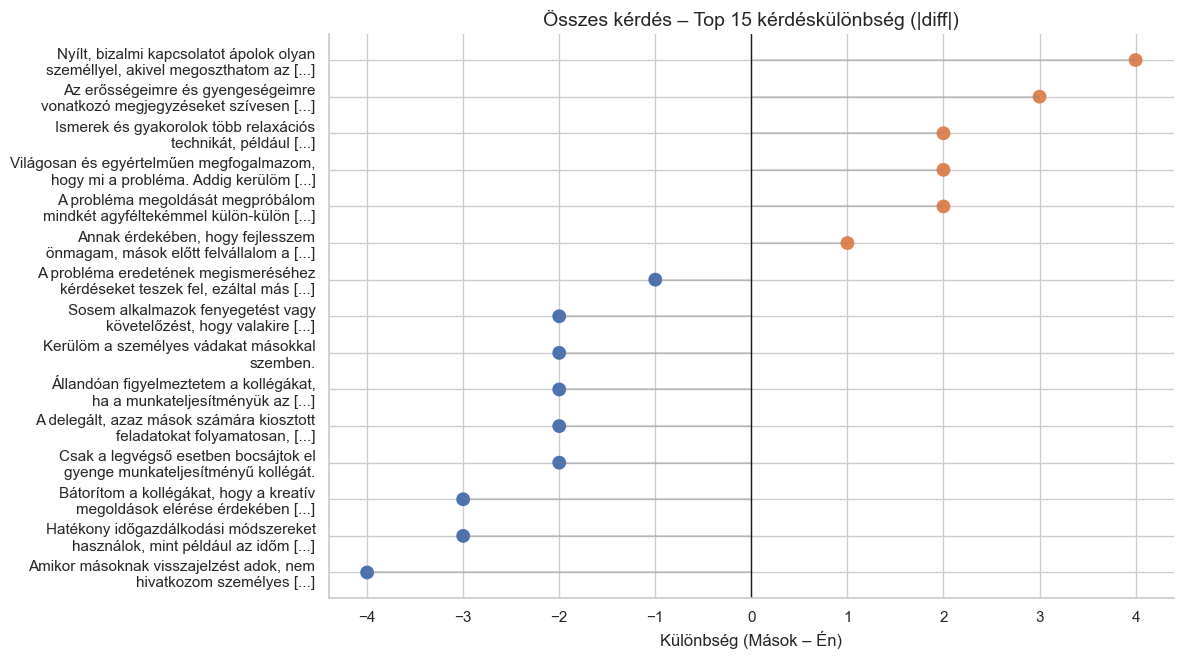

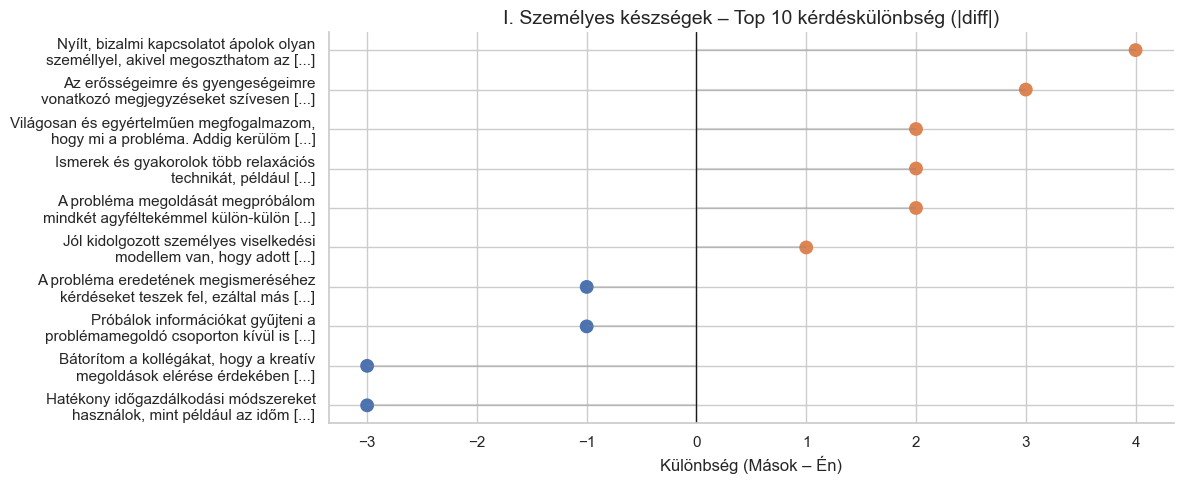

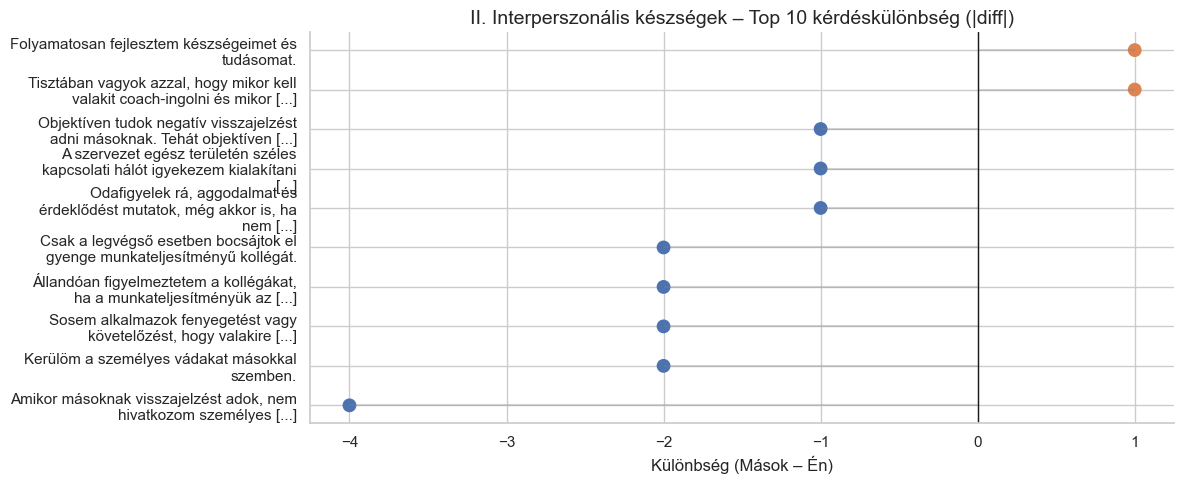

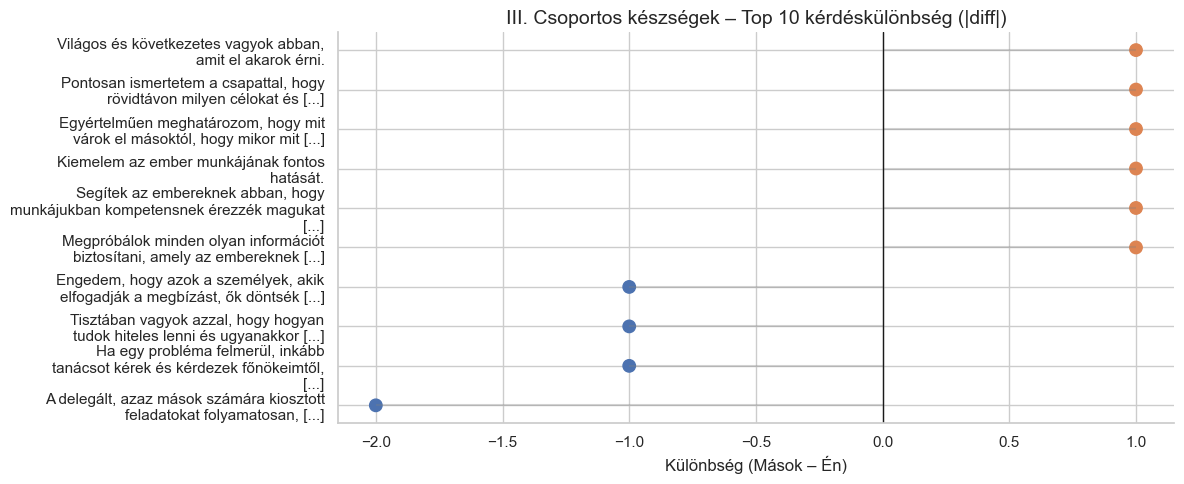

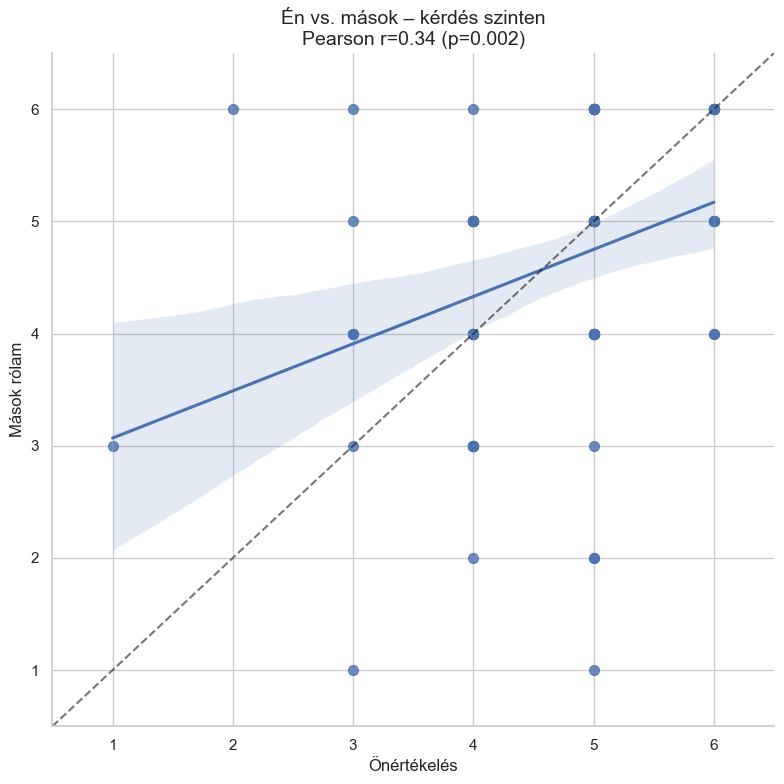

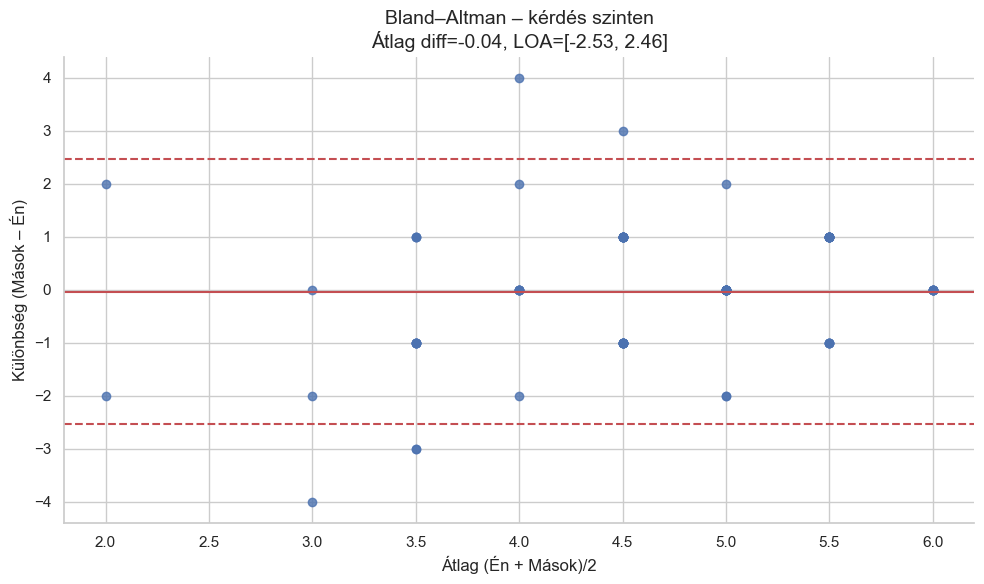

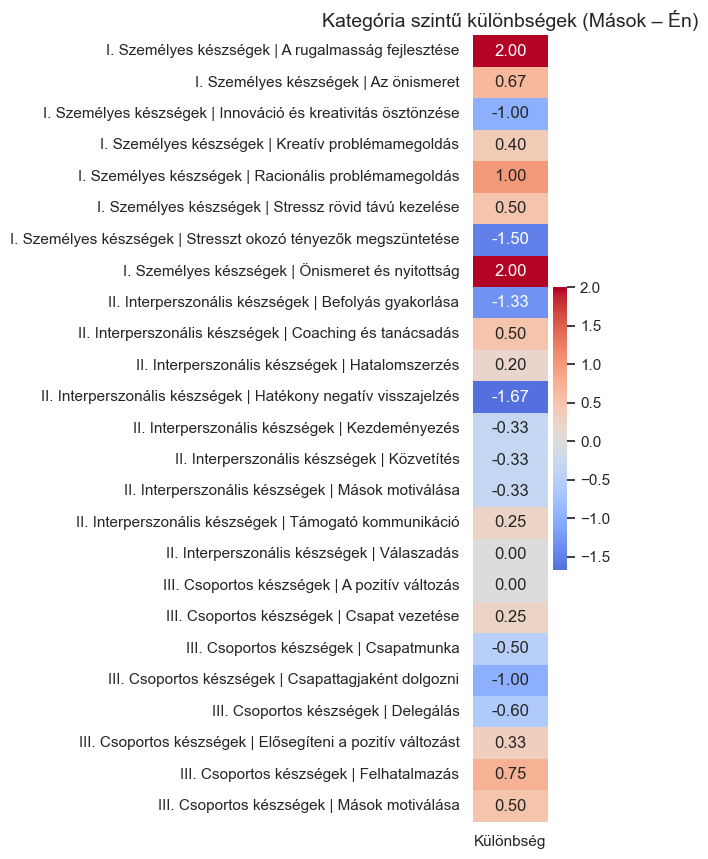

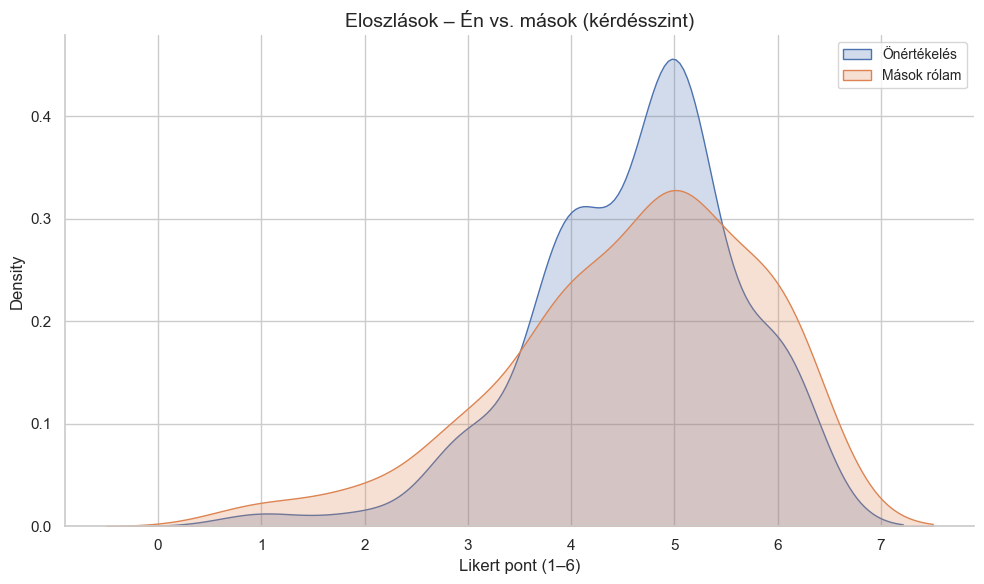

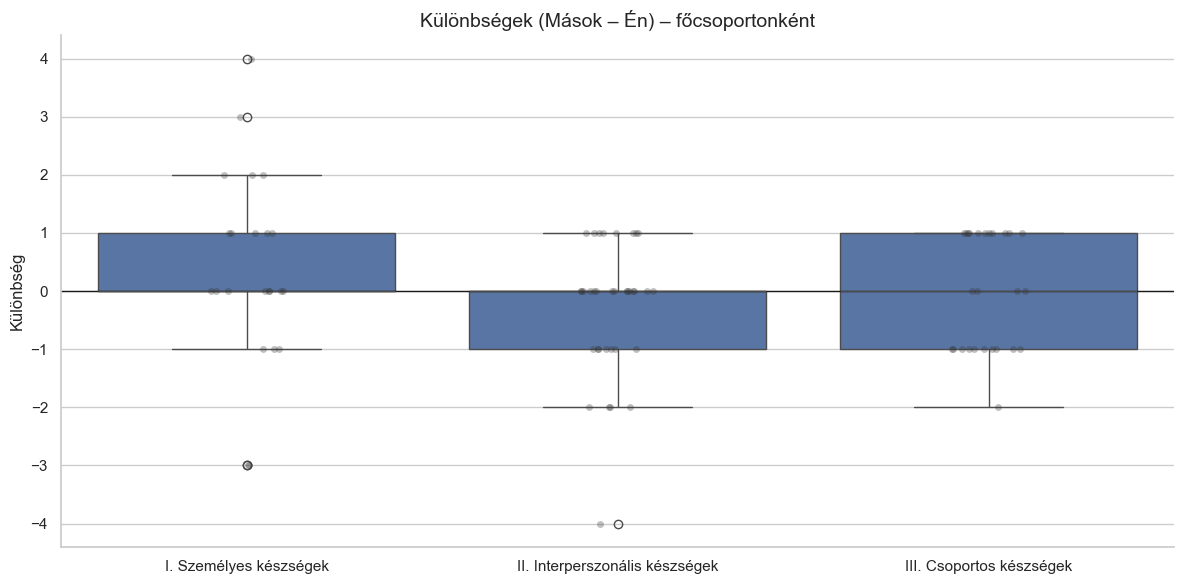

In [11]:
# Kérdés-szintű összehasonlítások és eloszlások
# 4) Top különbségek kérdésszinten
lollipop_top_diffs(val, top=15, title_prefix="Összes kérdés")
for mg in ["I. Személyes készségek", "II. Interperszonális készségek", "III. Csoportos készségek"]:
    lollipop_top_diffs(val[val["main_group"]==mg], top=10, title_prefix=f"{mg}")

# 5) Szórásdiagram és korreláció
scatter_self_vs_others(val, title="Én vs. mások – kérdés szinten")

# 6) Bland–Altman
bland_altman(val, title="Bland–Altman – kérdés szinten")

# 7) Kategória szintű hőtérkép (átlagkülönbségek kérdésekből)
df_cat = (val.groupby(["main_group","category"], dropna=False)
           .agg({"self":"mean", "others":"mean"})
           .reset_index())
df_cat["diff"] = df_cat["others"] - df_cat["self"]
heatmap_category_diff(df_cat, title="Kategória szintű különbségek (Mások – Én)")

# 8) Eloszlások – hisztogramok
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(val["self"], fill=True, label="Önértékelés")
sns.kdeplot(val["others"], fill=True, label="Mások rólam")
ax.set_title("Eloszlások – Én vs. mások (kérdésszint)")
ax.set_xlabel("Likert pont (1–6)")
ax.legend()
sns.despine(ax=ax)
savefig(fig, "Eloszlások – Én vs. mások (kérdésszint)")

# 9) Különbségek eloszlása főcsoportonként
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(data=val, x="main_group", y="diff", whis=1.5)
sns.stripplot(data=val, x="main_group", y="diff", alpha=0.3, color="#333")
ax.axhline(0, color='k', lw=1)
ax.set_title("Különbségek (Mások – Én) – főcsoportonként")
ax.set_xlabel("")
ax.set_ylabel("Különbség")
sns.despine(ax=ax)
savefig(fig, "Különbségek – főcsoportonként")

# 10) Táblázat – legnagyobb pozitív és negatív különbségek
pd.options.display.max_colwidth = 120
print("Legnagyobb pozitív különbségek (Mások > Én):")
display(val.sort_values("diff", ascending=False).head(10)[["id","text","self","others","diff","main_group","category"]])
print("\nLegnagyobb negatív különbségek (Én > Mások):")
display(val.sort_values("diff", ascending=True).head(10)[["id","text","self","others","diff","main_group","category"]])